Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [74]:
import pathlib
from glob import glob
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [75]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [76]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path('gdrive/My Drive/CNN_Cancerdetection/Images/Train')
data_dir_test = pathlib.Path('gdrive/My Drive/CNN_Cancerdetection/Images/Test')

In [77]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [78]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [79]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
                            data_dir_train,
                            validation_split=0.2,
                            subset="training",
                            seed=123,
                            image_size=(img_height, img_width),
                            batch_size=batch_size,
                            color_mode='rgb',
                            shuffle=True,
                        )


Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [80]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
                            data_dir_train,
                            validation_split=0.2,
                            subset="validation",
                            seed=123,
                            image_size=(img_height, img_width),
                            batch_size=batch_size,
                            color_mode='rgb',
                            shuffle=True,
                        )


Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [81]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

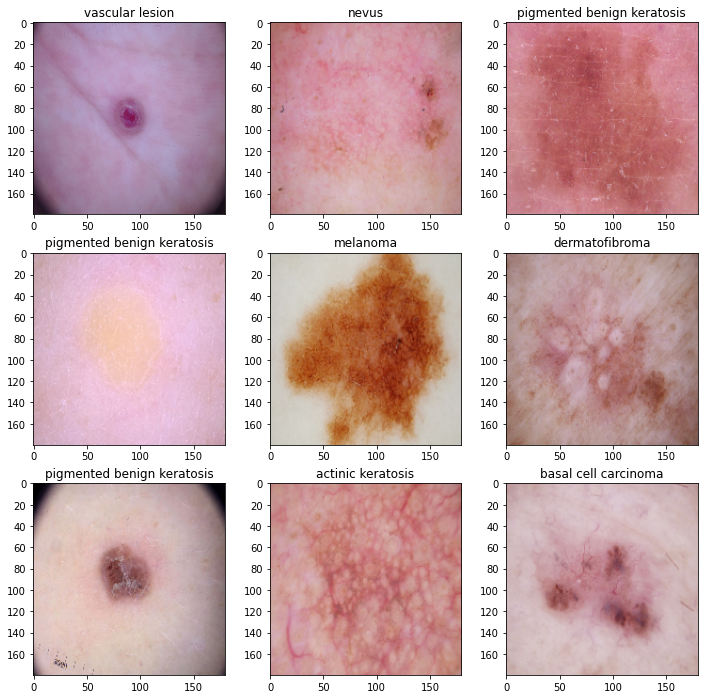

In [82]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [83]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model - First Model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [84]:
### Your code goes here
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
num_classes = 9

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [85]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [86]:
# View the summary of all layers
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_7 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 22, 22, 64)       

### Train the model

In [87]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 4s 72ms/step - loss: 2.0537 - accuracy: 0.2260 - val_loss: 1.9297 - val_accuracy: 0.2617
Epoch 2/20
56/56 [==============================] - 1s 22ms/step - loss: 1.7607 - accuracy: 0.3650 - val_loss: 1.5661 - val_accuracy: 0.4966
Epoch 3/20
56/56 [==============================] - 1s 21ms/step - loss: 1.4810 - accuracy: 0.4816 - val_loss: 1.3967 - val_accuracy: 0.5436
Epoch 4/20
56/56 [==============================] - 1s 21ms/step - loss: 1.4132 - accuracy: 0.5017 - val_loss: 1.5644 - val_accuracy: 0.4072
Epoch 5/20
56/56 [==============================] - 1s 21ms/step - loss: 1.2704 - accuracy: 0.5419 - val_loss: 1.4693 - val_accuracy: 0.4743
Epoch 6/20
56/56 [==============================] - 1s 21ms/step - loss: 1.1985 - accuracy: 0.5731 - val_loss: 1.4077 - val_accuracy: 0.5548
Epoch 7/20
56/56 [==============================] - 1s 21ms/step - loss: 1.1753 - accuracy: 0.5770 - val_loss: 1.3461 - val_accuracy: 0.5459
Epoch 8/20
56

### Visualizing training results

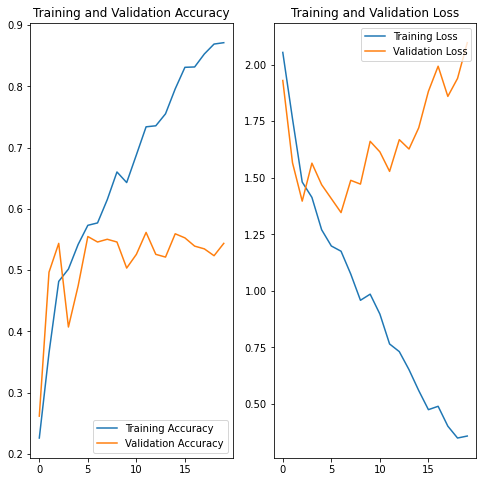

In [88]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit.

## THERE IS SIGN OF OVERFITTING.

In [89]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here

data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

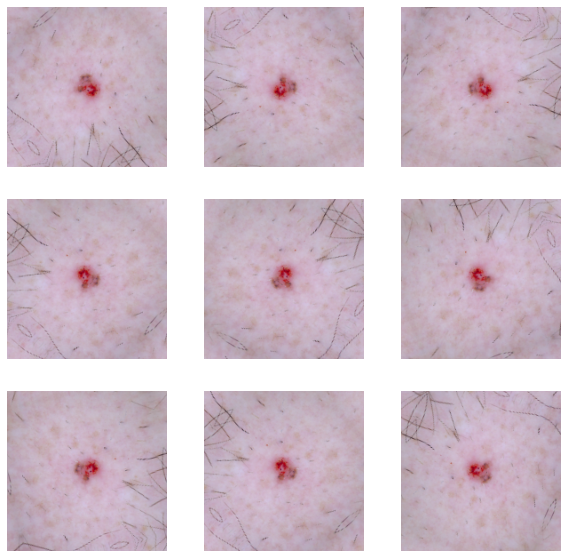

In [90]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

# Add the image to a batch
image = tf.expand_dims(image_batch, 0)

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

### MODEL 2
### Create the model, compile and train the model


In [91]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])



### Compiling the model

In [92]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [93]:
## Your code goes here, note: train your model for 20 epochs
## your training code
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 2s 26ms/step - loss: 2.1002 - accuracy: 0.2344 - val_loss: 1.8645 - val_accuracy: 0.3400
Epoch 2/20
56/56 [==============================] - 2s 27ms/step - loss: 1.7742 - accuracy: 0.3683 - val_loss: 1.6316 - val_accuracy: 0.4072
Epoch 3/20
56/56 [==============================] - 1s 23ms/step - loss: 1.5537 - accuracy: 0.4609 - val_loss: 1.4714 - val_accuracy: 0.4944
Epoch 4/20
56/56 [==============================] - 1s 23ms/step - loss: 1.4871 - accuracy: 0.4877 - val_loss: 1.5274 - val_accuracy: 0.4743
Epoch 5/20
56/56 [==============================] - 1s 23ms/step - loss: 1.4007 - accuracy: 0.5061 - val_loss: 1.4137 - val_accuracy: 0.5436
Epoch 6/20
56/56 [==============================] - 1s 23ms/step - loss: 1.3663 - accuracy: 0.5184 - val_loss: 1.3565 - val_accuracy: 0.5369
Epoch 7/20
56/56 [==============================] - 1s 23ms/step - loss: 1.3218 - accuracy: 0.5413 - val_loss: 1.3566 - val_accuracy: 0.5414
Epoch 8/20
56

### Visualizing the results

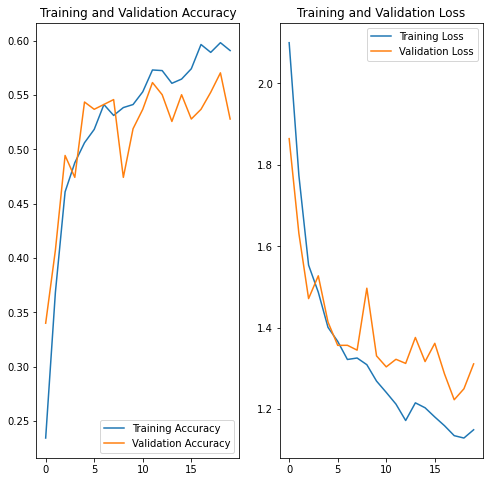

In [94]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?
## THERE IS VERY CLEAR EVIDENCE THAT THIS HELPED. THE MODEL IS NOT OVERFITTING ANYMORE. BUT STILL THE LOSS AND ERROR CAN BE REDUCED.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

<BarContainer object of 9 artists>

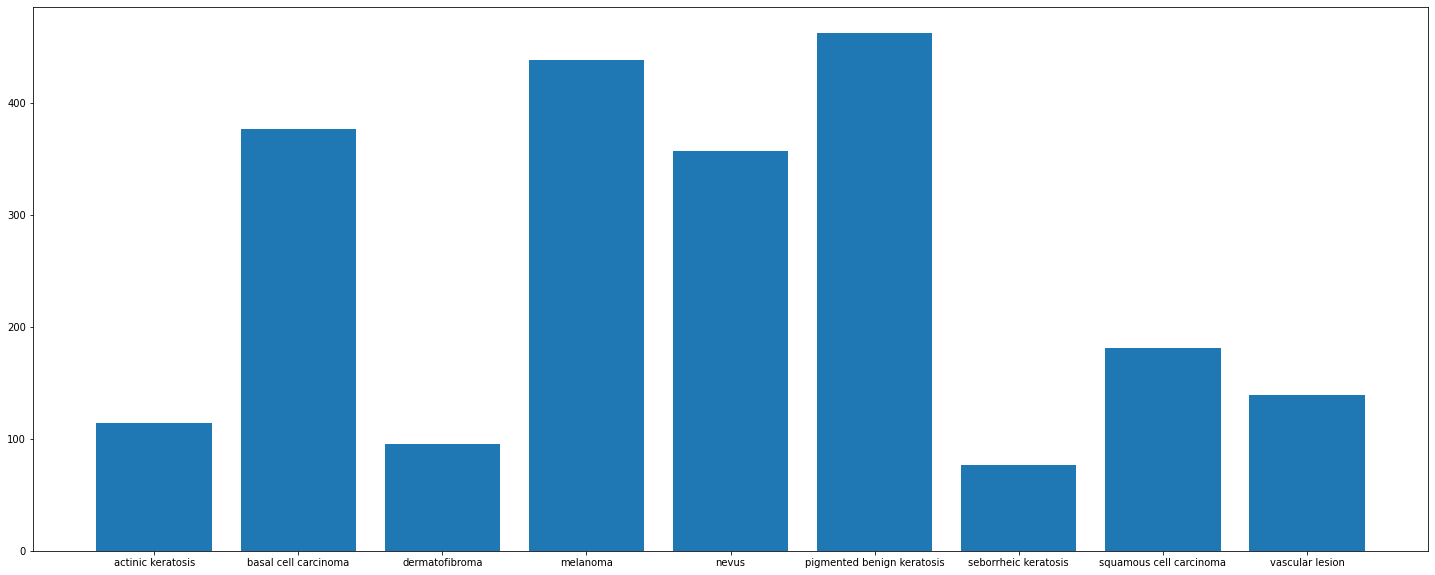

In [95]:
## Your code goes here.
count=[]
for i in class_names:
    count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(class_names,count)

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
### SEBORRHEIC KERATOSIS has the least number of samples.
#### - Which classes dominate the data in terms proportionate number of samples?
### PIGMENTED BENIGN KERATOSIS has the highest number of samples.

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [96]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [97]:
path_to_training_dataset = "gdrive/My Drive/CNN_Cancerdetection/Images/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(pathlib.Path(path_to_training_dataset + i))
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 114 image(s) found.
Output directory set to gdrive/My Drive/CNN_Cancerdetection/Images/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD6C404C990>: 100%|██████████| 500/500 [00:20<00:00, 24.61 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 376 image(s) found.
Output directory set to gdrive/My Drive/CNN_Cancerdetection/Images/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD6C2787890>: 100%|██████████| 500/500 [00:20<00:00, 24.88 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 95 image(s) found.
Output directory set to gdrive/My Drive/CNN_Cancerdetection/Images/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD6C4244B10>: 100%|██████████| 500/500 [00:20<00:00, 23.92 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 438 image(s) found.
Output directory set to gdrive/My Drive/CNN_Cancerdetection/Images/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=722x540 at 0x7FD721088790>: 100%|██████████| 500/500 [01:35<00:00,  5.21 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 357 image(s) found.
Output directory set to gdrive/My Drive/CNN_Cancerdetection/Images/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=957x723 at 0x7FD6BFC781D0>: 100%|██████████| 500/500 [01:29<00:00,  5.58 Samples/s]
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FD6BE9F8F10>:   0%|          | 1/500 [00:00<01:03,  7.84 Samples/s]

Initialised with 462 image(s) found.
Output directory set to gdrive/My Drive/CNN_Cancerdetection/Images/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD6BFAF3150>: 100%|██████████| 500/500 [00:20<00:00, 24.75 Samples/s]
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7FD6C41A2650>:   0%|          | 1/500 [00:00<00:53,  9.38 Samples/s]

Initialised with 77 image(s) found.
Output directory set to gdrive/My Drive/CNN_Cancerdetection/Images/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FD7291EFE90>: 100%|██████████| 500/500 [00:41<00:00, 11.96 Samples/s]
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FD720EF32D0>:   0%|          | 1/500 [00:00<01:10,  7.06 Samples/s]

Initialised with 181 image(s) found.
Output directory set to gdrive/My Drive/CNN_Cancerdetection/Images/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD6BE4351D0>: 100%|██████████| 500/500 [00:20<00:00, 24.63 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD721079490>:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 139 image(s) found.
Output directory set to gdrive/My Drive/CNN_Cancerdetection/Images/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD7291EFE90>: 100%|██████████| 500/500 [00:20<00:00, 24.04 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [98]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [99]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['gdrive/My Drive/CNN_Cancerdetection/Images/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028820.jpg_e4d5618b-8c55-4f85-aff9-af6093a93e28.jpg',
 'gdrive/My Drive/CNN_Cancerdetection/Images/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027615.jpg_cd6c6723-a320-4833-adab-25b4b5276352.jpg',
 'gdrive/My Drive/CNN_Cancerdetection/Images/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026525.jpg_ed6171d6-46ec-40c0-8192-0e667806cbef.jpg',
 'gdrive/My Drive/CNN_Cancerdetection/Images/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029915.jpg_2c7fe3ea-6f31-4801-a62c-33b76c9e67aa.jpg',
 'gdrive/My Drive/CNN_Cancerdetection/Images/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0025803.jpg_8f87cea1-de7c-4e57-bcc2-64c3ff163fc5.jpg',
 'gdrive/My Drive/CNN_Cancerdetection/Images/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029025.jpg_f5cfaed5-807a-4cd2-8a5e-30ddffaa5e9e.jpg',
 'gdrive/My Drive/CNN_

In [100]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [101]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [102]:
#THIS MAY NOT BE REQUIRED
path_list_old = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_old = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output' ,'*.jpg'))]
dataframe_dict_old = dict(zip(path_list_old, lesion_list_old))
original_df = pd.DataFrame(list(dataframe_dict_old.items()),columns = ['Path','Label'])

In [103]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [104]:
new_df['Label'].value_counts()

actinic keratosis             1000
nevus                         1000
pigmented benign keratosis    1000
squamous cell carcinoma       1000
vascular lesion               1000
basal cell carcinoma          1000
melanoma                      1000
seborrheic keratosis          1000
dermatofibroma                1000
Name: Label, dtype: int64

### OBSERVE THAT THE NUMBER OF SAMPLES FROM ALL 9 CLASSES ARE SAME.

#### **Todo**: Train the model on the data created using Augmentor

In [105]:
print(data_dir_train)

gdrive/My Drive/CNN_Cancerdetection/Images/Train


#### **Todo:** Create a training dataset

In [106]:
## data_dir_train="path to directory with training data + data created using augmentor"
## pathlib.Path('gdrive/My Drive/CNN_Cancerdetection/Images/Train')
print(data_dir_train)
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode='categorical')

gdrive/My Drive/CNN_Cancerdetection/Images/Train
Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [107]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode='categorical')

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)
### MODEL 3

In [108]:
## your code goes here
## your code goes here
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [109]:
## your code goes here
## your code goes here
model.compile(optimizer='adam',
              loss=keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [110]:
epochs = 30
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 34s 191ms/step - loss: 7.6695 - accuracy: 0.1384 - val_loss: 7.1676 - val_accuracy: 0.1403
Epoch 2/30
169/169 [==============================] - 33s 192ms/step - loss: 7.1354 - accuracy: 0.1434 - val_loss: 7.1676 - val_accuracy: 0.1403
Epoch 3/30
169/169 [==============================] - 33s 190ms/step - loss: 7.1354 - accuracy: 0.1434 - val_loss: 7.1676 - val_accuracy: 0.1403
Epoch 4/30
169/169 [==============================] - 33s 191ms/step - loss: 7.1354 - accuracy: 0.1434 - val_loss: 7.1676 - val_accuracy: 0.1403
Epoch 5/30
169/169 [==============================] - 33s 188ms/step - loss: 7.1354 - accuracy: 0.1434 - val_loss: 7.1676 - val_accuracy: 0.1403
Epoch 6/30
169/169 [==============================] - 32s 187ms/step - loss: 7.1354 - accuracy: 0.1434 - val_loss: 7.1676 - val_accuracy: 0.1403
Epoch 7/30
169/169 [==============================] - 32s 187ms/step - loss: 7.1354 - accuracy: 0.1434 - val_loss: 7.1676 - val_ac

#### **Todo:**  Visualize the model results

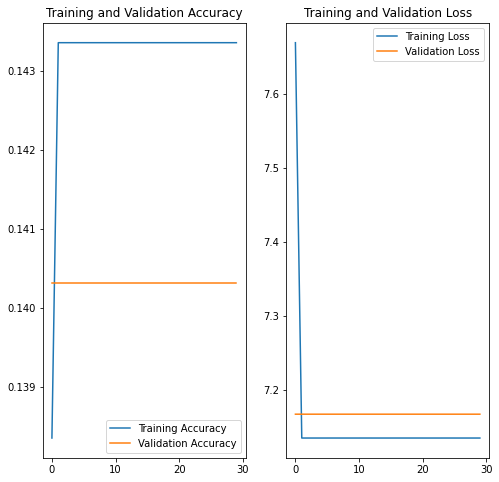

In [111]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



Looks like rebalancing didn't help address underfitting / overfitting.